## Panchromatic sharpening  ##

Info: [Fundamentals of panchromatic sharpening][1]


  [1]: http://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/fundamentals-of-panchromatic-sharpening.htm

In [1]:
# libs
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rescale
import skimage.color as color

In [2]:
# read m and p data
IM_ID = '6120_2_2'
m = tiff.imread('../input/sixteen_band/{}_M.tif'.format(IM_ID))
pan = tiff.imread('../input/sixteen_band/{}_P.tif'.format(IM_ID))

print ('m_shape: ', m.shape)
print ('pan_shape: ', pan.shape)

m_shape:  (8, 837, 851)
pan_shape:  (3348, 3403)


In [3]:
# functions 
def stretch(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands)
    for i in range(3):
        a = 0 
        b = 255 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.uint8)

def pansharpen(m, pan, method='browley', W=0.1, all_data=False):
    
    # get m_bands
    rgbn = np.empty((m.shape[1], m.shape[2], 4)) 
    rgbn[:,:,0] = m[4,:,:] # red
    rgbn[:,:,1] = m[2,:,:] # green
    rgbn[:,:,2] = m[1,:,:] # blue
    rgbn[:,:,3] = m[6,:,:] # NIR-1
    
    # scaled them
    rgbn_scaled = np.empty((m.shape[1]*4, m.shape[2]*4, 4))

    for i in range(4):
        img = rgbn[:,:,i]
        scaled = rescale(img, (4,4))
        rgbn_scaled[:,:,i] = scaled
    
    # check size and crop for pan band
    if pan.shape[0] < rgbn_scaled.shape[0]:
        rgbn_scaled = rgbn_scaled[:pan.shape[0],:, :]
    else:
        pan = pan[:rgbn_scaled.shape[0], :]
        
    if pan.shape[1] < rgbn_scaled.shape[1]:
        rgbn_scaled = rgbn_scaled[:,:pan.shape[1], :]
    else:
        pan = pan[:,:rgbn_scaled.shape[1]]

    R = rgbn_scaled[:,:,0]
    G = rgbn_scaled[:,:,1]
    B = rgbn_scaled[:,:,2]
    I = rgbn_scaled[:,:,3]

    image = None

    if method == 'simple_browley':
        all_in = R+G+B
        prod = np.multiply(all_in, pan)

        r = np.multiply(R, pan/all_in)[:, :, np.newaxis]
        g = np.multiply(G, pan/all_in)[:, :, np.newaxis]
        b = np.multiply(B, pan/all_in)[:, :, np.newaxis]

        image = np.concatenate([r,g,b], axis=2)
    
    if method == 'sample_mean':
        r = 0.5 * (R + pan)[:, :, np.newaxis]
        g = 0.5 * (G + pan)[:, :, np.newaxis]
        b = 0.5 * (B + pan)[:, :, np.newaxis]
        
        image = np.concatenate([r,g,b], axis=2)
        
    if method == 'esri':
        ADJ = pan-rgbn_scaled.mean(axis=2) 
        r = (R + ADJ)[:, :, np.newaxis]
        g = (G + ADJ)[:, :, np.newaxis]
        b = (B + ADJ)[:, :, np.newaxis]
        i = (I + ADJ)[:, :, np.newaxis]
        
        image = np.concatenate([r,g,b,i], axis=2)
    
    if method == 'browley':
        DNF = (pan - W*I)/(W*R+W*G+W*B)

        r = (R * DNF)[:, :, np.newaxis]
        g = (G * DNF)[:, :, np.newaxis]
        b = (B * DNF)[:, :, np.newaxis]
        i = (I * DNF)[:, :, np.newaxis]

        image = np.concatenate([r,g,b,i], axis=2)
    
    if method == 'hsv':
        hsv = color.rgb2hsv(rgbn_scaled[:,:,:3])
        hsv[:,:,2] = pan - I*W
        image = color.hsv2rgb(hsv)
        
    if all_data:
        return rgbn_scaled, image, I
    else:
        return image

In [4]:
rgbn, sharpened_browley_simple, I = pansharpen(m, pan, method='simple_browley', all_data=True)
sharpened_mean = pansharpen(m, pan, method='sample_mean')
sharpened_esri = pansharpen(m, pan, method='esri')

sharpened_browley2 = pansharpen(m, pan, W=0.1)
sharpened_browley4 = pansharpen(m, pan, W=0.2)
sharpened_browley6 = pansharpen(m, pan, W=0.3)
sharpened_browley8 = pansharpen(m, pan, W=0.4)

sharpened_ihs2 = pansharpen(m, pan, method='hsv', W=0.1)
sharpened_ihs4 = pansharpen(m, pan, method='hsv', W=0.2)
sharpened_ihs6 = pansharpen(m, pan, method='hsv', W=0.3)
sharpened_ihs8 = pansharpen(m, pan, method='hsv', W=0.4)

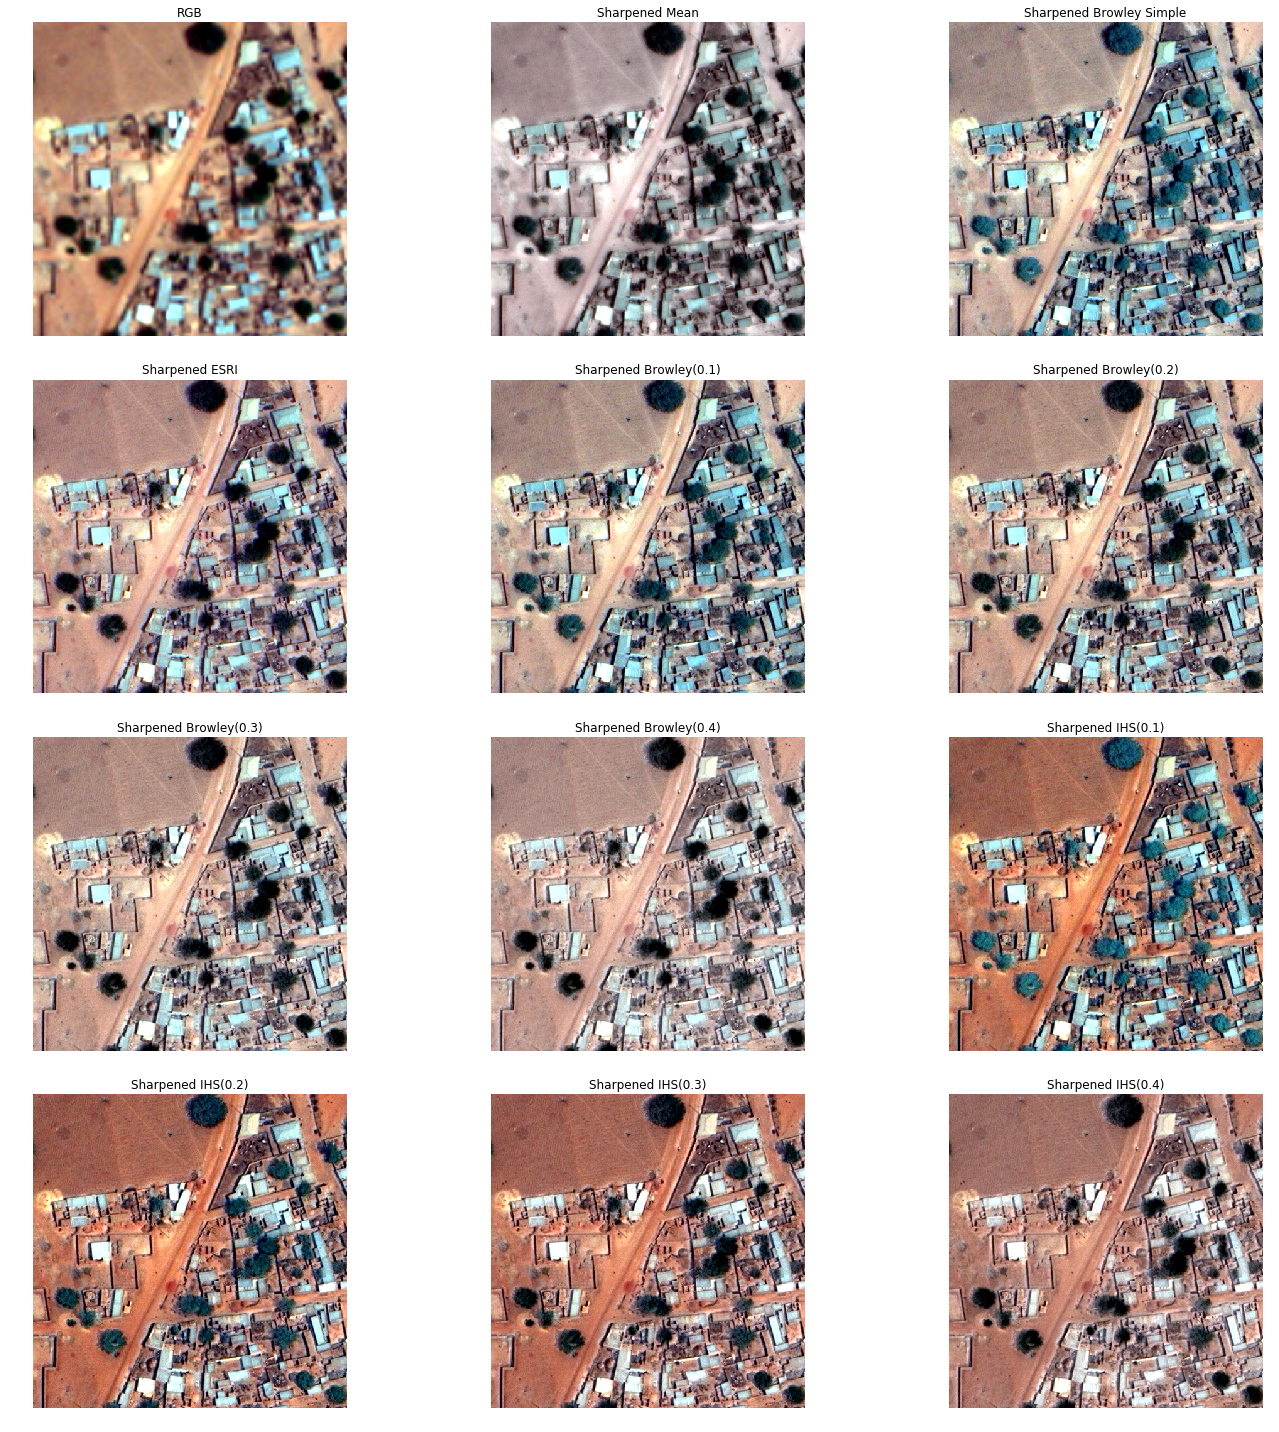

In [5]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(20, 20))
ax = axes.ravel()

# no IR sharpening
ax[0].imshow(stretch(rgbn[500:1000,500:1000,:3]))
ax[0].set_title('RGB')
ax[0].axis('off')
ax[1].imshow(stretch(sharpened_mean[500:1000,500:1000,:]))
ax[1].set_title('Sharpened Mean')    
ax[1].axis('off')
ax[2].imshow(stretch(sharpened_browley_simple[500:1000,500:1000,:]))
ax[2].set_title('Sharpened Browley Simple')
ax[2].axis('off')
ax[3].imshow(stretch(sharpened_esri[500:1000,500:1000,:3]))
ax[3].set_title('Sharpened ESRI')
ax[3].axis('off')

# IR Browley
ax[4].imshow(stretch(sharpened_browley2[500:1000,500:1000,:3]))
ax[4].set_title('Sharpened Browley(0.1)')
ax[4].axis('off')
ax[5].imshow(stretch(sharpened_browley4[500:1000,500:1000,:3]))
ax[5].set_title('Sharpened Browley(0.2)')
ax[5].axis('off')
ax[6].imshow(stretch(sharpened_browley6[500:1000,500:1000,:3]))
ax[6].set_title('Sharpened Browley(0.3)')
ax[6].axis('off')
ax[7].imshow(stretch(sharpened_browley8[500:1000,500:1000,:3]))
ax[7].set_title('Sharpened Browley(0.4)')
ax[7].axis('off')

# IR HSV
ax[8].imshow(stretch(sharpened_ihs2[500:1000,500:1000,:3]))
ax[8].set_title('Sharpened IHS(0.1)')
ax[8].axis('off')
ax[9].imshow(stretch(sharpened_ihs4[500:1000,500:1000,:3]))
ax[9].set_title('Sharpened IHS(0.2)')
ax[9].axis('off')
ax[10].imshow(stretch(sharpened_ihs6[500:1000,500:1000,:3]))
ax[10].set_title('Sharpened IHS(0.3)')
ax[10].axis('off')
ax[11].imshow(stretch(sharpened_ihs8[500:1000,500:1000,:3]))
ax[11].set_title('Sharpened IHS(0.4)')
ax[11].axis('off')

plt.tight_layout()
plt.show()